# Scaffolding

In [2]:
import requests
import scipy
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
import statsmodels.formula.api as smf
from IPython.display import display, clear_output
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, Checkbox, HBox, VBox
import ipywidgets as widgets

In [3]:
#pd.set_option('display.max_colwidth', 10000)
#pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

In [4]:
%matplotlib inline

In [5]:
day1comments = {
    '84295': 'Sample A blue filter',
    '84294': 'Sample B blue filter',
    '84293': 'Sample A Pour 2 Take 2',
    '84292': 'Sample B Pour 2 Take 2',
    '84286': 'Sample B Pour 1',
    '84287': 'Sample A Pour 1',
    '84288': 'Sample B Pour 1 Take 2',
    '84289': 'Sample A Pour 1 Take 2',
    '84290': 'Sample B Pour 2',
    '84291': 'Sample A Pour 2',
}

In [6]:
def plot_multiple_wines(df, images_ser, axes=None):
    if axes is None:
        _, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20), sharey=True)
    else:
        ax1, ax2, ax3 = axes

    for id_, meta in df.iterrows():
        curve = images_ser.loc[(meta['normalize'], id_)]

        ax1.plot(
            curve.loc['r'],
            linestyle=meta['linestyle'],
            color=meta['color'],
            alpha=meta['alpha'],
            label=meta['label']
        )
        ax1.set_title("red")

        ax2.plot(
            curve.loc['g'],
            linestyle=meta['linestyle'],
            color=meta['color'],
            alpha=meta['alpha'],
            label=meta['pourlabel']
        )
        ax2.set_title("green")

        ax3.plot(
            curve.loc['b'],
            linestyle=meta['linestyle'],
            color=meta['color'],
            alpha=meta['alpha'],
        )
        ax3.set_title("blue")
        ax1.legend(loc='best', title='wine')
        ax2.legend(loc='best', title='pour')

In [7]:
def plot_multiple_wines_chan(df, images_ser):
    ax1 = plt.figure(figsize=(20, 16)).gca()

    for id_, meta in df.iterrows():
        curve = images_ser.loc[(meta['normalize'], id_)]

        ax1.plot(
            curve.loc['g'],
            linestyle=meta['linestyle'],
            color=meta['color'],
            alpha=meta['alpha'],
            label=meta['pourlabel']
        )
        ax1.set_title("green")
        ax1.legend(loc='best', title='pour')

In [8]:
colors4 = dict(zip(['A','B','C','D'], sns.color_palette('Set1', n_colors=4)))
colors7 = dict(zip(['A','B','C','D','E','F','G'], sns.color_palette('Set1', n_colors=7)))

def get_mean_significant_height(a):
    significant_height = np.percentile(a, 90)
    return a[a > significant_height].mean()

def norm_by_red_chan(a):
    rchan = a.xs('r', level='c')
    return a / rchan[rchan >= rchan.quantile(0.9)].mean()

def norm_by_indep_chan(a):
    return a / a[a >= a.quantile(0.9)].mean()

def norm_ser(a):
    significant_height = np.percentile(a, 90)
    return a / (a[a > significant_height].mean())

def iter_by_level(df, level=0):
    for idx, df_ in df.groupby(level=level):
        df_.reset_index(level=level, drop=True, inplace=True)
        yield idx, df_

def images_to_tidy(meta_df):
    ff = []
    for id_, meta in meta_df.iterrows():
        lo = meta['xlow']
        hi = meta['xhi']

        for chan, channame in zip([0,1,2], ['r','g','b']):
            samps = np.mean(images[id_][:,:,chan], axis=0)[lo:hi]
            len_ = hi-lo
            index = pd.MultiIndex.from_arrays(
                    ([id_] * len_,
                     [channame] * len_,
                     arange(hi-lo)),
                    names=['sid','c','x']
                )
            ff.append(pd.Series(samps, index=index))
    return pd.concat(ff)

def images_to_tidy_w_norm(meta_df):
    tidy = images_to_tidy(meta_df)
    tidy2 = tidy.groupby(level=['sid','c']).transform(norm_by_indep_chan)

    aa = pd.concat((
        (tidy
         .to_frame("sample")
         .assign(normalized=False)
         .set_index('normalized', append=True)
         .reorder_levels(['normalized','sid','c','x'])
         .sort_index()
         ['sample']),
        (tidy2
         .to_frame("sample")
         .assign(normalized=True)
         .set_index('normalized', append=True)
         .reorder_levels(['normalized','sid','c','x'])
         .sort_index()
         ['sample'])
        ))
    aa.name = None
    return aa

# ingest

In [9]:
ids = []
for page in [1,2,3,4,5]:
    for ln in requests.get("https://spectralworkbench.org/profile/b11z?page=%s" % page).content.decode().split("\n"):
        m = re.search(r'<h4>.*"/spectrums/([0-9]*)"', ln)
        if m:
            ids.append(m.group(1))

In [10]:
urls = (
    pd.Index(ids)
    .to_series().to_frame('urlid')
    .assign(
        url=lambda df: 'https://spectralworkbench.org/spectrums/' + df.urlid,
        meta_url=lambda df: 'https://spectralworkbench.org/spectrums/' + df.urlid + ".json",
        sample_url=lambda df: 'https://spectralworkbench.org/system/photos/' + df.urlid + '/original/capture.png',
    )
)
#urls.head()

In [13]:
#metaj = {}
for id_, url in urls.meta_url.items():
    if id_ not in metaj:
        print(url)
        metaj[id_] = json.loads(requests.get(url).content.decode())

https://spectralworkbench.org/spectrums/84583.json
https://spectralworkbench.org/spectrums/84582.json
https://spectralworkbench.org/spectrums/84581.json
https://spectralworkbench.org/spectrums/84580.json
https://spectralworkbench.org/spectrums/84579.json
https://spectralworkbench.org/spectrums/84578.json
https://spectralworkbench.org/spectrums/84577.json
https://spectralworkbench.org/spectrums/84576.json
https://spectralworkbench.org/spectrums/84575.json
https://spectralworkbench.org/spectrums/84573.json
https://spectralworkbench.org/spectrums/84572.json
https://spectralworkbench.org/spectrums/84571.json
https://spectralworkbench.org/spectrums/84570.json
https://spectralworkbench.org/spectrums/84569.json
https://spectralworkbench.org/spectrums/84568.json
https://spectralworkbench.org/spectrums/84567.json
https://spectralworkbench.org/spectrums/84566.json
https://spectralworkbench.org/spectrums/84565.json
https://spectralworkbench.org/spectrums/84564.json
https://spectralworkbench.org/s

In [14]:
#images = {}
for id_, url in urls.sample_url.items():
    if id_ not in images:
        print(url)
        images[id_] = (
            scipy.misc.imread(
                io.BytesIO(
                    requests.get(url).content)))

https://spectralworkbench.org/system/photos/84583/original/capture.png
https://spectralworkbench.org/system/photos/84582/original/capture.png
https://spectralworkbench.org/system/photos/84581/original/capture.png
https://spectralworkbench.org/system/photos/84580/original/capture.png
https://spectralworkbench.org/system/photos/84579/original/capture.png
https://spectralworkbench.org/system/photos/84578/original/capture.png
https://spectralworkbench.org/system/photos/84577/original/capture.png
https://spectralworkbench.org/system/photos/84576/original/capture.png
https://spectralworkbench.org/system/photos/84575/original/capture.png
https://spectralworkbench.org/system/photos/84573/original/capture.png
https://spectralworkbench.org/system/photos/84572/original/capture.png
https://spectralworkbench.org/system/photos/84571/original/capture.png
https://spectralworkbench.org/system/photos/84570/original/capture.png
https://spectralworkbench.org/system/photos/84569/original/capture.png
https:

# analysis (event, N3)

In [15]:
structs = (pd.DataFrame.from_dict(metaj, orient='index')
 [['calibrated', 'created_at','notes','title']]
 .pipe(lambda df: df[df.title.str.startswith("N3 W")])
 .pipe(lambda df: df.join(
            df.title.str.extract(r"W(?P<round_>[12]?)(?P<wineltr>[ABCDEFG]) P(?P<pour>.) S(?P<sample_>.)", expand=True)
        )
    )
 .assign(
    round_=lambda df: df.round_.where(df.round_!='', '0').astype(int),
    pour=lambda df: df.pour.astype(int),
    sample_=lambda df: df.sample_.astype(int),
 )
 .assign(wine=lambda df:df.round_.astype(str)+df.wineltr)
 .assign(xlow=lambda df: 0)
 .assign(xhi=lambda df: (df.xlow+640).astype(int))
 # 0E pour1 looks identical to 0F
 .assign(weirdsamp=lambda df: (df.wine == '0E') & (df.pour == 1))
)

images_ser = images_to_tidy_w_norm(structs)

x_idx = images_ser.index.get_level_values('x').unique()
        
display(structs.groupby(['round_','wine']).size())
structs.head(2)

round_  wine
0       0A      4
        0B      4
        0C      4
        0D      3
        0E      3
        0F      3
        0G      1
1       1A      5
        1B      4
        1C      4
        1D      4
        1E      4
        1F      4
        1G      4
2       2A      4
        2B      4
        2C      4
        2D      4
        2E      4
        2F      4
        2G      4
dtype: int64

,calibrated,created_at,notes,title,round_,wineltr,pour,sample_,wine,xlow,xhi,weirdsamp
84504,False,2016-08-26T00:41:48Z,,N3 WA P1 S1,0,A,1,1,0A,0,640,False
84505,False,2016-08-26T00:42:27Z,,N3 WB P1 S1,0,B,1,1,0B,0,640,False


guess table
- 0F = 1A 0.95   De Bila
- 0C = 1B 0.8    Ringbolt
- 0G = 1C 0.98   Bel Air
- 0A = 1D 0.8    Girard
- 0D = 1E 0.7    Bonterra
- 0B = 1F 0.7    Wakefield
- 0E = 1G 0.95   Domaine Les Pins


- 0G = 2A 0.98   Bel Air
- 0A = 2B 0.75   Girard
- 0B = 2C 0.7    Wakefield
- 0E = 2D 0.95   Les Pins
- 0F = 2E 0.95   De Bila
- 0C = 2F 0.7    Ringbolt
- 0D = 2G 0.7    Bonterra

0D approx= 1E based on unnormalized blue and green overall level

0D approx= 2G, process of elim w/ 0B and 2C

0A == 1D, based on overall G,B level

0A == 2B, based on overall G,B level, but not as confident

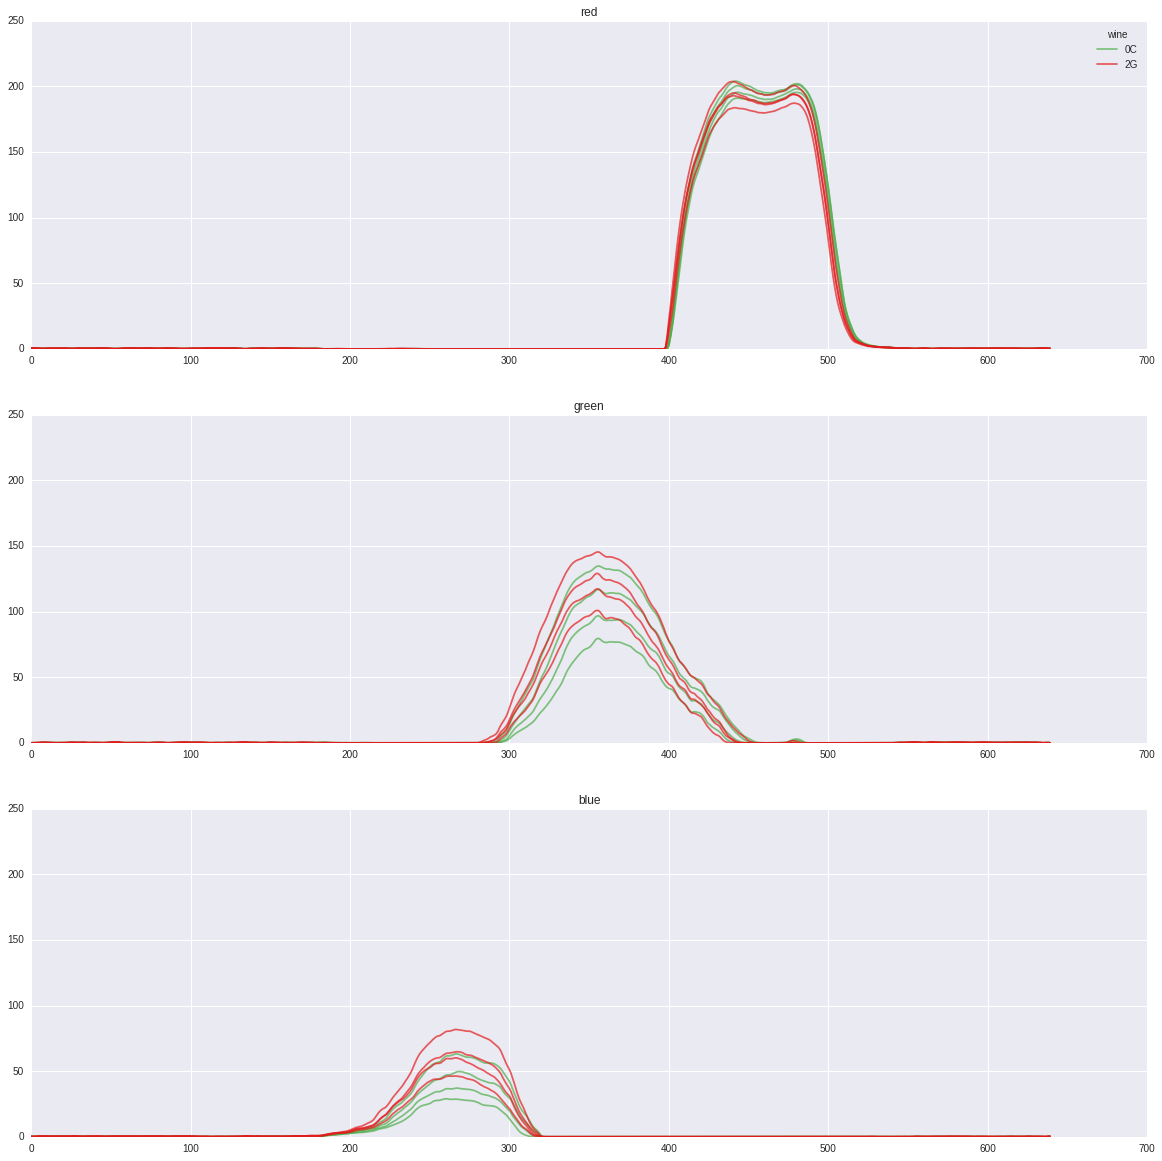

In [184]:
meta_df = (structs
      .assign(
        color=lambda df: df.wine.str[1:].map(lambda s: colors7['A' if s in ['F','G'] else s]),
        #color=lambda df: pd.Series([list(colors4.values())[0]]*len(df), index=df.index),
        linestyle='-',
        #linestyle='-',
        alpha=0.7,
        label=lambda df: df.wine.where((df.pour == 1) & (df.sample_ == 1), None),
        pourlabel=lambda df: df.pour.where((df.wine == 'D') & (df.sample_ == 1), None),
        normalize=False,
      )
      .pipe(lambda df: df[~df.weirdsamp])
      .pipe(lambda df: df[~df.wine.isin(['0G','1C','2A','0E','0F','1A', '1G','2E','0D','1E','2C','0A','1D','2B'])])
     )

chk = VBox([HBox([Checkbox(description=str(round_)+wine, value=round_==0) for wine in sorted(colors7.keys()) if str(round_)+wine in meta_df.wine.values])for round_ in [0,1,2]])

def updatePlot(*args):
    selected = set(
        c2.description
        for c in chk.children
        for c2 in c.children
        if c2.value)

    clear_output()
    plot_multiple_wines(
        meta_df[meta_df.wine.isin(selected)],
        images_ser
    )
for c in chk.children:
    for c2 in c.children:
        c2.observe(updatePlot, names='value')
updatePlot()
chk

In [94]:
structs.query('round_ == 0').join(images_ser.loc[True].xs('b', level='c').xs(274, level='x').to_frame("b274"))[['wine','b274']].sort_values('b274')

,wine,b274
84509,0F,1.054943
84508,0E,1.057824
84515,0F,1.067259
84522,0G,1.072605
84514,0E,1.073157
84521,0F,1.074195
84520,0E,1.096760
84512,0C,1.116101
84513,0D,1.117042
84510,0A,1.118633


In [169]:
(structs
 #.query('round_ == 0')
 .pipe(lambda df: df[df.wine.isin(['0B','0C','1B','1F','2F','2G'])])
 [['wine']]
 .join((images_ser.loc[True].xs('g', level='c').xs(340, level='x') /  images_ser.loc[True].xs('g', level='c').xs(375, level='x')).to_frame("grat340_375"))
 .sort_values('grat340_375')
)

,wine,grat340_375
84517,0B,0.736616
84525,0C,0.833649
84524,0B,0.856669
84505,0B,0.882188
84511,0B,0.890080
84518,0C,0.900022
84527,1B,0.908815
84545,1F,0.914259
84538,1F,0.933536
84506,0C,0.937568


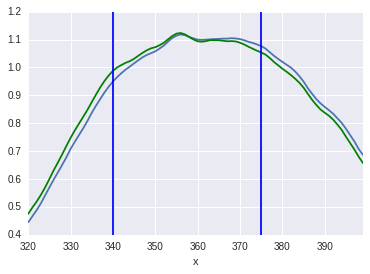

In [154]:
images_ser.loc[(True, meta_df.query('wine=="0B"').index[0], 'g')].iloc[320:400].plot()
images_ser.loc[(True, meta_df.query('wine=="0C"').index[0], 'g')].iloc[320:400].plot(color='g')
plt.axvline(340)
plt.axvline(375)

In [25]:
meta_df.head()

,calibrated,created_at,notes,title,round_,wineltr,pour,sample_,wine,xlow,xhi,weirdsamp,alpha,color,label,linestyle,normalize,pourlabel
84504,False,2016-08-26T00:41:48Z,,N3 WA P1 S1,0,A,1,1,0A,0,640,False,0.7,"(0.89411765337, 0.101960785687, 0.109803922474)",0A,-,True,None
84505,False,2016-08-26T00:42:27Z,,N3 WB P1 S1,0,B,1,1,0B,0,640,False,0.7,"(0.216024608004, 0.494871203806, 0.719876986976)",0B,-,True,None
84506,False,2016-08-26T00:43:06Z,,N3 WC P1 S1,0,C,1,1,0C,0,640,False,0.7,"(0.304267601289, 0.683291060551, 0.292933499696)",0C,-,True,None
84507,False,2016-08-26T00:43:41Z,,N3 WD P1 S1,0,D,1,1,0D,0,640,False,0.7,"(0.600830473619, 0.30814303335, 0.631695522982)",0D,-,True,None
84508,False,2016-08-26T00:44:15Z,,N3 WE P1 S1,0,E,1,1,0E,0,640,True,0.7,"(1.0, 0.505913110457, 0.00313725494871)",0E,-,True,None


In [2]:
import io
import base64
def sparkplot(callable, figsize=(4, 0.25)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    callable(ax)

    img = io.BytesIO()
    plt.savefig(img)
    img.seek(0)
    plt.close()
    return '<img src=\"data:image/png;base64,{}\"/>'.format(base64.b64encode(img.read()).decode())

In [71]:
sns.set_color_codes(palette='deep')

def plot_rgb(ax, ser):
    ax.plot(ser['r'].loc[180:550], color='r')
    ax.plot(ser['g'].loc[180:550], color='g')
    ax.plot(ser['b'].loc[180:550], color='b')
    ax.set_ylim(0, 1.5)

names={
    'A': '2012 Girard Napa Cabernet Sauvignon',
    'B': '2013 Wakefield Cabernet Sauvignon Clare Valley',
    'C': '2013 Ringbolt Cabernet Sauvignon Margaret River',
    'D': '2013 Bonterra Mendocino Cabernet Sauvignon',
    'E': '2014 Domaine Les Pins Loire Cabernet Franc',
    'F': '2014 Domaine de Bila Haut Languedoc-Roussillon Rhone Blend',
    'G': '1996 Bel Air Lagrave Bordeaux Cab Blend',
}

(meta_df
 .query('round_ == 0')
 .assign(plot=lambda df: df.index.map(lambda sid: sparkplot(lambda ax: plot_rgb(ax, images_ser.loc[(True, sid)]))))
 .assign(name=lambda df: df.wineltr.map(names.__getitem__))
 [['name','pour','wineltr','sample_','wine','plot',]]
 .style)

In [116]:
foo = (
    pd.DataFrame.from_dict(metaj, orient='index')
    .assign(xlow=0, xhi=520))

images_foo = images_to_tidy_w_norm(foo)

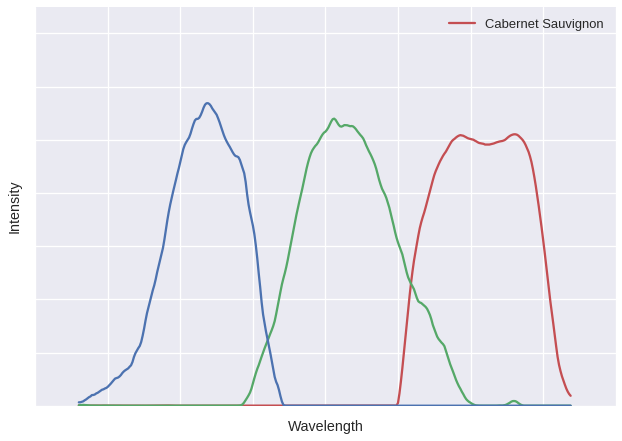

In [154]:
sns.set_context('talk')
#plt.figure(figsize=(16, 10), dpi=180)
plt.figure()
ax = plt.gca()

ser = images_foo.loc[True, '84506']
ax.plot(ser['r'].loc[180:550], color='r', label='Cabernet Sauvignon')
ax.plot(ser['g'].loc[180:550], color='g', label='__nolabel__')
ax.plot(ser['b'].loc[180:550], color='b', label='__nolabel__')
ax.set_ylim(0, 1.5)

ax.set_xlabel("Wavelength")
ax.set_ylabel("Intensity")
ax.set_xticklabels(['' for i in plt.gca().get_xticks()]);
ax.set_yticklabels(['' for i in plt.gca().get_xticks()]);

plt.legend(loc='best')
plt.savefig('test2.png', dpi=300)

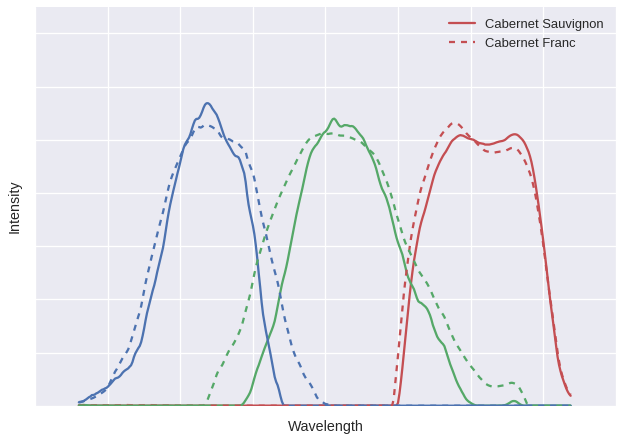

In [150]:
sns.set_context('talk')
#plt.figure(figsize=(18, 12))
ax = plt.gca()

ser = images_foo.loc[True, '84506']
ax.plot(ser['r'].loc[180:550], color='r', label='Cabernet Sauvignon')
ax.plot(ser['g'].loc[180:550], color='g', label='__nolabel__')
ax.plot(ser['b'].loc[180:550], color='b', label='__nolabel__')
ax.set_ylim(0, 1.5)

ax.set_xlabel("Wavelength")
ax.set_ylabel("Intensity")
ax.set_xticklabels(['' for i in plt.gca().get_xticks()]);
ax.set_yticklabels(['' for i in plt.gca().get_xticks()]);

ser = images_foo.loc[True, '84514']
ax.plot(ser['r'].loc[180:550], color='r', linestyle='--', label='Cabernet Franc')
ax.plot(ser['g'].loc[180:550], color='g', linestyle='--', label='__nolabel__')
ax.plot(ser['b'].loc[180:550], color='b', linestyle='--', label='__nolabel__')
plt.legend(loc='best')
plt.savefig('test.png', dpi=300)

/home/brian/bin/ipython3-env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


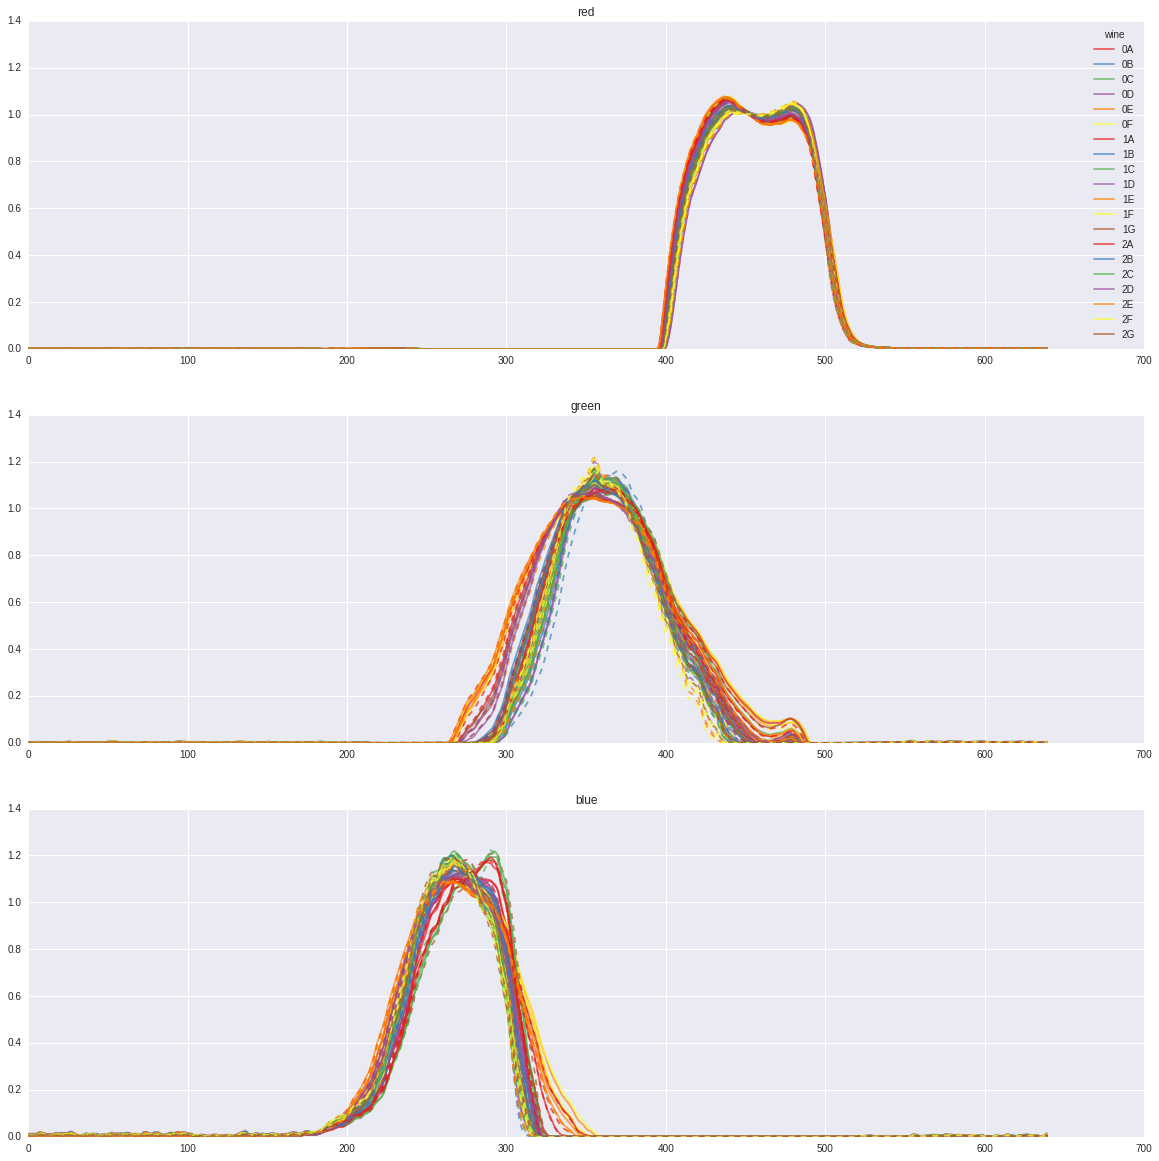

In [18]:
meta_df = (structs
      .assign(
        color=lambda df: df.wine.str[1:].map(lambda s: colors7[s]),
        linestyle=lambda df: (df.pour-1).map(['-','--','-.'].__getitem__),
        #linestyle='-',
        alpha=0.7,
        label=lambda df: df.wine.where((df.pour == 1) & (df.sample_ == 1), None),
        pourlabel=lambda df: df.pour.where((df.wine == 'D') & (df.sample_ == 1), None),
        normalize=True,
      )
     )

plt.figure()
plot_multiple_wines(
    meta_df,
    images_ser
)

/home/brian/bin/ipython3-env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


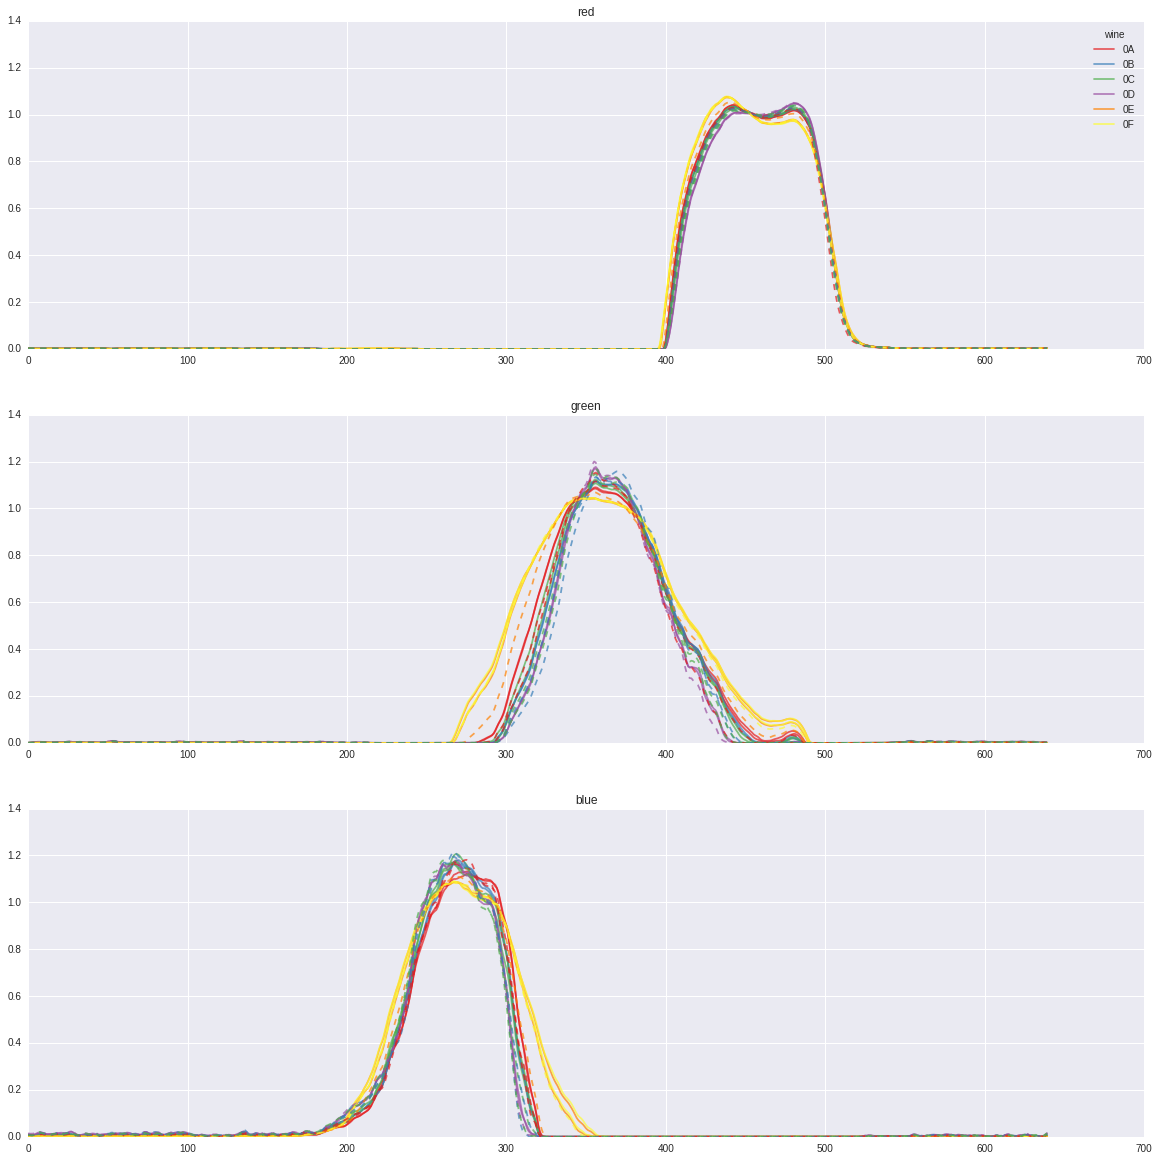

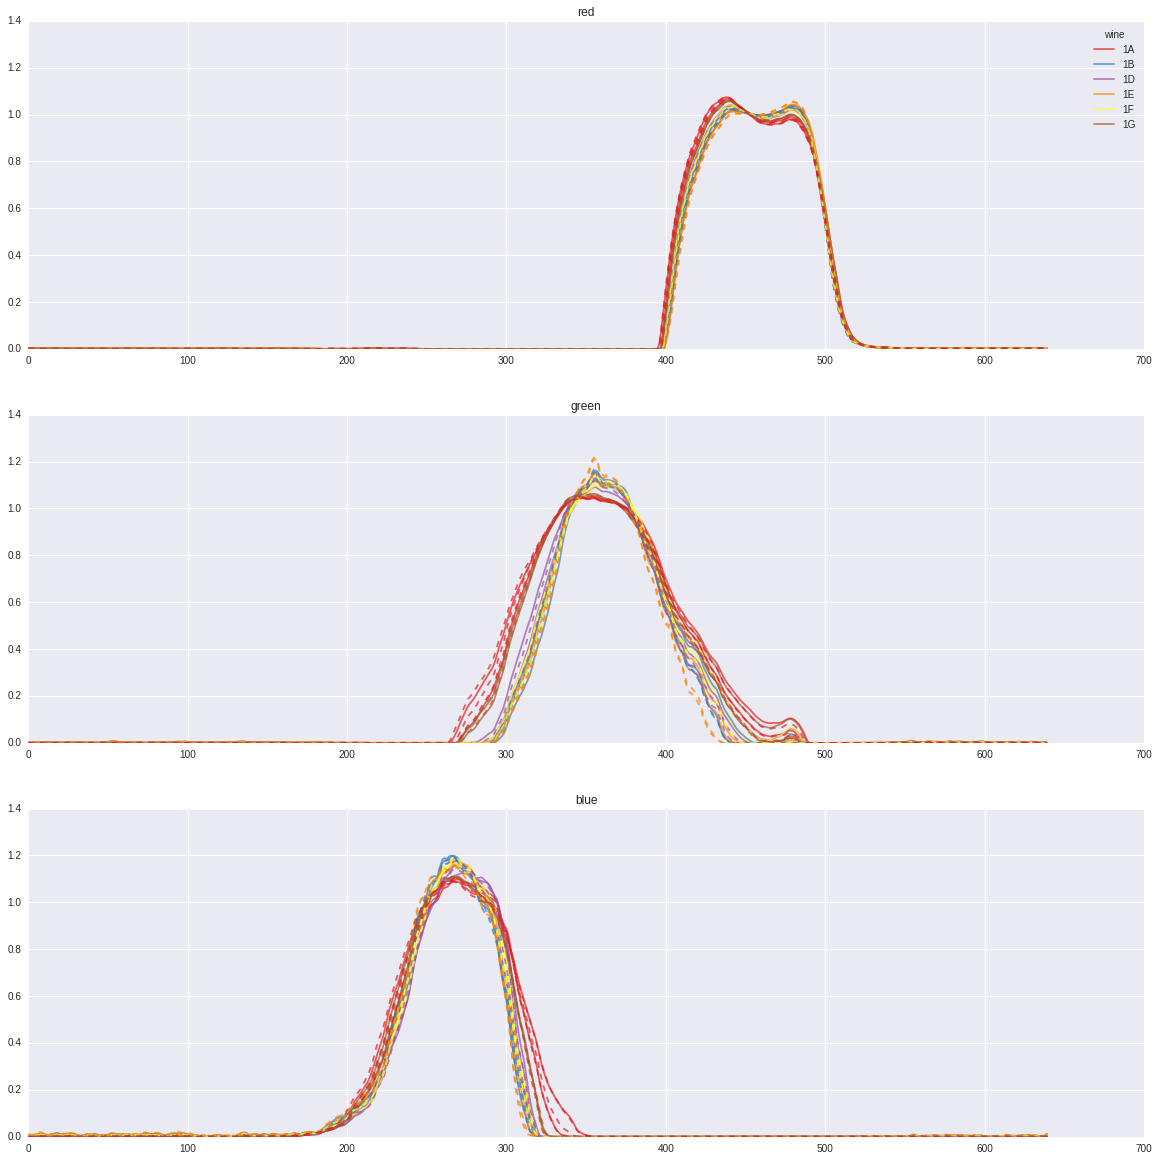

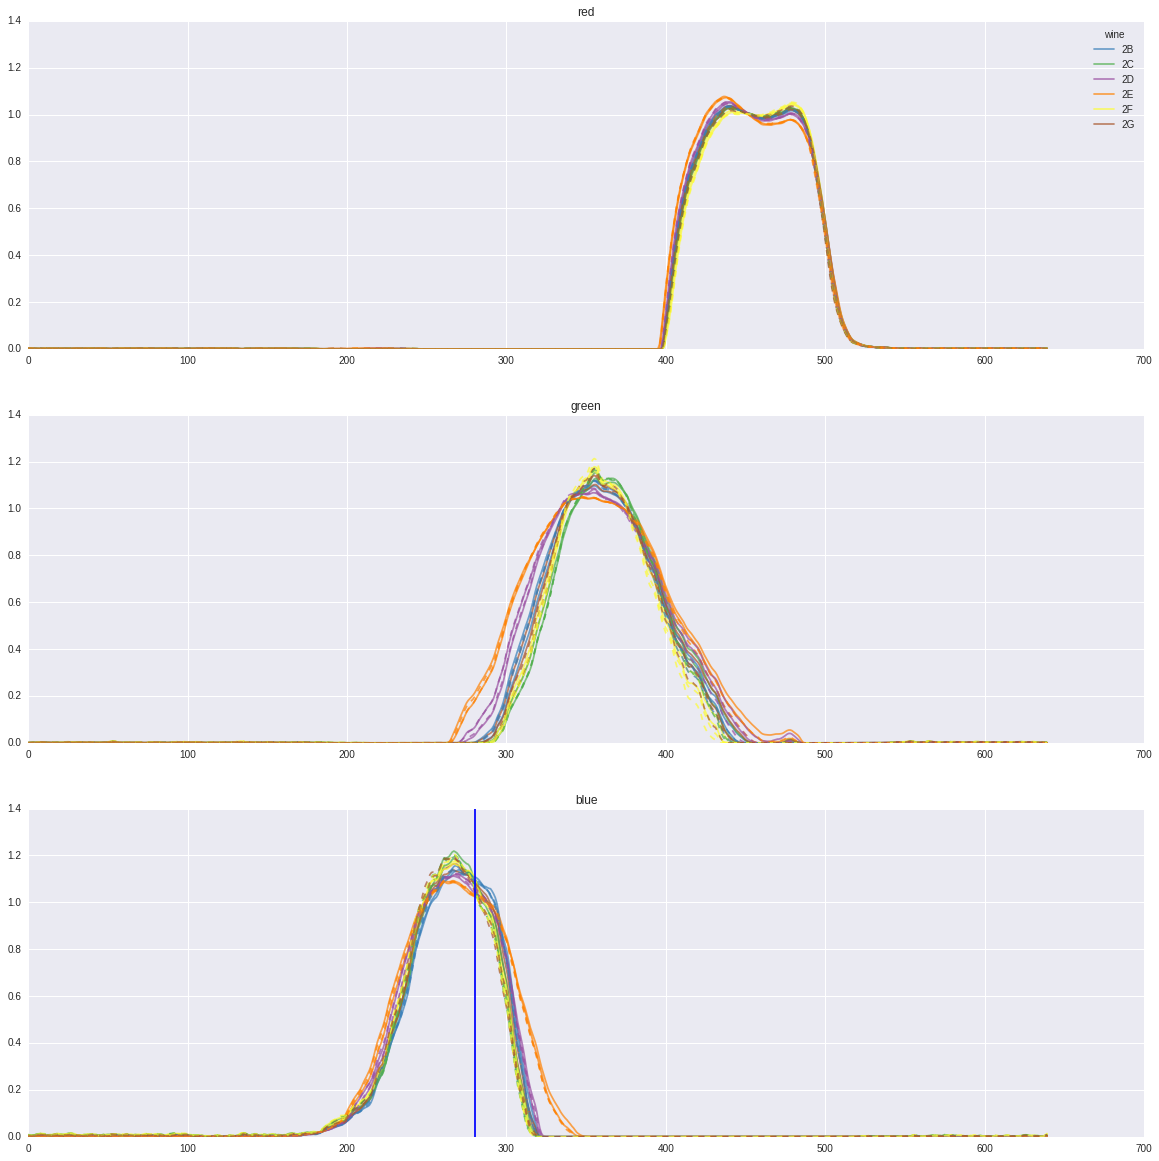

In [71]:
meta_df = (structs
      .assign(
        color=lambda df: df.wine.str[1:].map(lambda s: colors7[s]),
        linestyle=lambda df: (df.pour-1).map(['-','--','-.'].__getitem__),
        #linestyle='-',
        alpha=0.7,
        label=lambda df: df.wine.where((df.pour == 1) & (df.sample_ == 1), None),
        pourlabel=lambda df: df.pour.where((df.wine == 'D') & (df.sample_ == 1), None),
        normalize=True,
      )
     )

plt.figure()
plot_multiple_wines(
    meta_df.query("round_ == 0 and wine != '0G'"),
    images_ser
)

plt.figure()
plot_multiple_wines(
    meta_df.query("round_ == 1 and wine != '1C'"),
    images_ser
)

plt.figure()
plot_multiple_wines(
    meta_df.query("round_ == 2 and wine != '2A'"),
    images_ser
)
plt.gca().axvline(280)

# analysis (dry run, N2)

In [369]:
structs = (pd.DataFrame.from_dict(metaj, orient='index')
 [['calibrated', 'created_at','notes','title']]
 .pipe(lambda df: df[df.title.str.startswith("N2 W")])
 .pipe(lambda df: df.join(
            df.title.str.extract(r"W(?P<wine>.) P(?P<pour>.) S(?P<sample_>.) BF", expand=True)
        )
    )
 .assign(
    knocked_spectro = lambda df: df.created_at >= df.loc['84465', 'created_at'],
    capture_macos = lambda df: df.created_at >= df.loc['84468', 'created_at'],
    weirdo = lambda df: df.created_at >= df.loc['84460', 'created_at'],
    pour=lambda df: df.pour.astype(int),
    sample_=lambda df: df.sample_.astype(int),
    )
 .assign(xlow=lambda df: df.capture_macos.map(lambda v: 138 if v else 140).astype(int))
 .assign(xhi=lambda d2: (d2.xlow+380).astype(int))
)

images_ser = images_to_tidy(structs)
x_idx = images_ser.index.get_level_values('x').unique()
        
structs.head(2)

,calibrated,created_at,notes,title,wine,pour,sample_,capture_macos,knocked_spectro,weirdo,xlow,xhi
84437,False,2016-08-25T04:26:48Z,Day 2 wine A pour 1 sample 1 blue filter,N2 WA P1 S1 BF,A,1,1,False,False,False,140,520
84439,False,2016-08-25T04:28:30Z,,N2 WB P1 S1 BF,B,1,1,False,False,False,140,520


/home/brian/bin/ipython3-env/lib/python3.5/site-packages/ipykernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/brian/bin/ipython3-env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


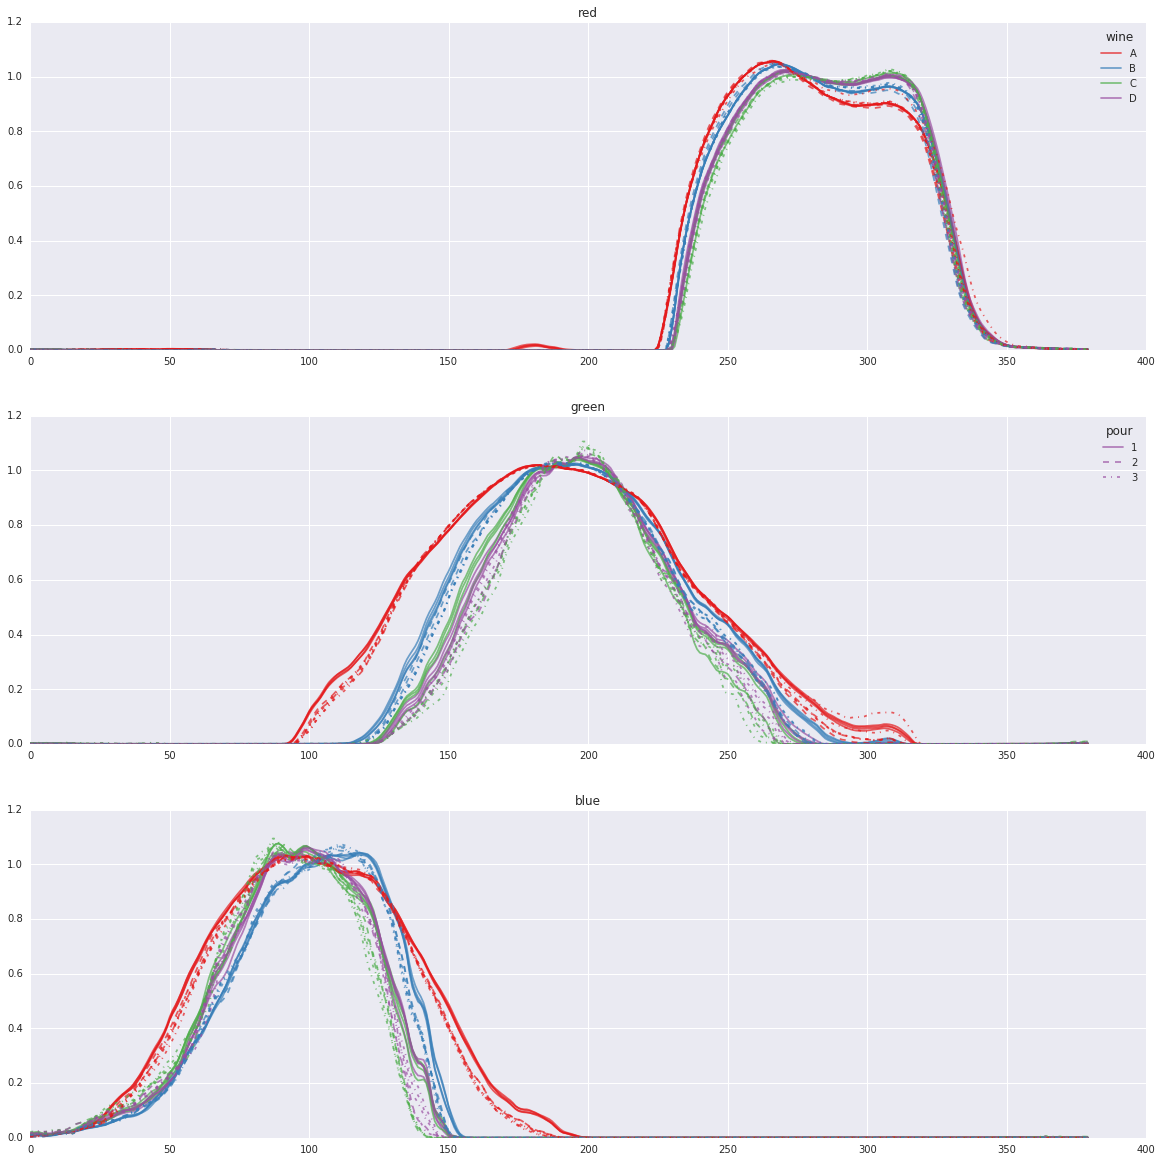

In [371]:
meta_df = (structs
      .assign(
        color=lambda df: df.wine.map(lambda s: colors4[s]),
        linestyle=lambda df: (df.pour-1).map(['-','--','-.'].__getitem__),
        #linestyle='-',
        alpha=0.7,
        label=lambda df: df.wine.where((df.pour == 1) & (df.sample_ == 1), None),
        pourlabel=lambda df: df.pour.where((df.wine == 'D') & (df.sample_ == 1), None),
        normalize=True,
      )
      #.query("(wine != 'A')")
      #.query("(wine != 'B')")
      #.query("(wine != 'C')")
     )

#plt.figure()
plot_multiple_wines(
    meta_df.query('pour != 2 or (pour == 2 and not capture_macos and not knocked_spectro and not weirdo)'),
    images_ser
)

/home/brian/bin/ipython3-env/lib/python3.5/site-packages/ipykernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/brian/bin/ipython3-env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


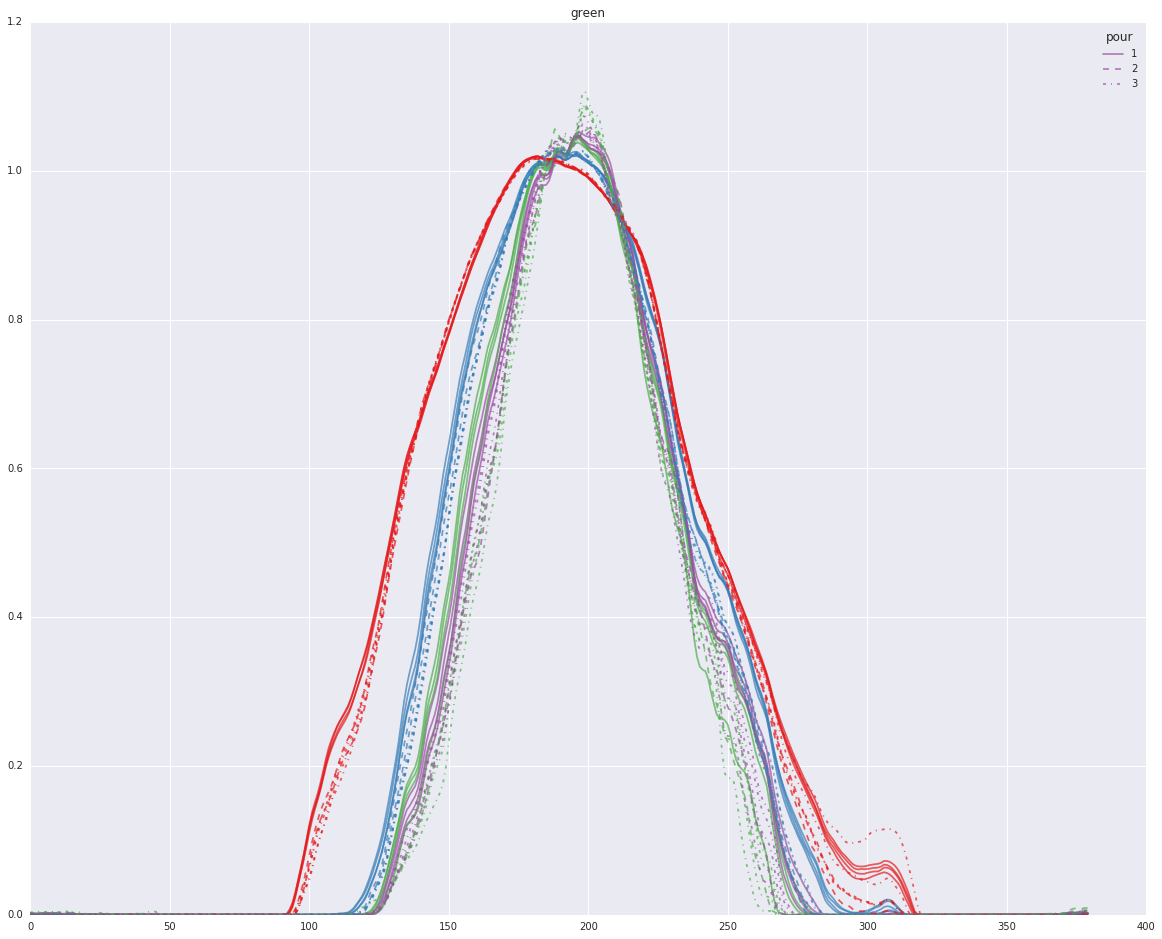

In [618]:
meta_df = (structs
      .assign(
        color=lambda df: df.wine.map(lambda s: colors4[s]),
        linestyle=lambda df: (df.pour-1).map(['-','--','-.'].__getitem__),
        #linestyle='-',
        alpha=0.7,
        label=lambda df: df.wine.where((df.pour == 1) & (df.sample_ == 1), None),
        pourlabel=lambda df: df.pour.where((df.wine == 'D') & (df.sample_ == 1), None),
        normalize=True,
      )
      #.query("(wine != 'A')")
      #.query("(wine != 'B')")
      #.query("(wine != 'C')")
     )

#plt.figure()
plot_multiple_wines_chan(
    meta_df.query('pour != 2 or (pour == 2 and not capture_macos and not knocked_spectro and not weirdo)'),
    images_ser
)

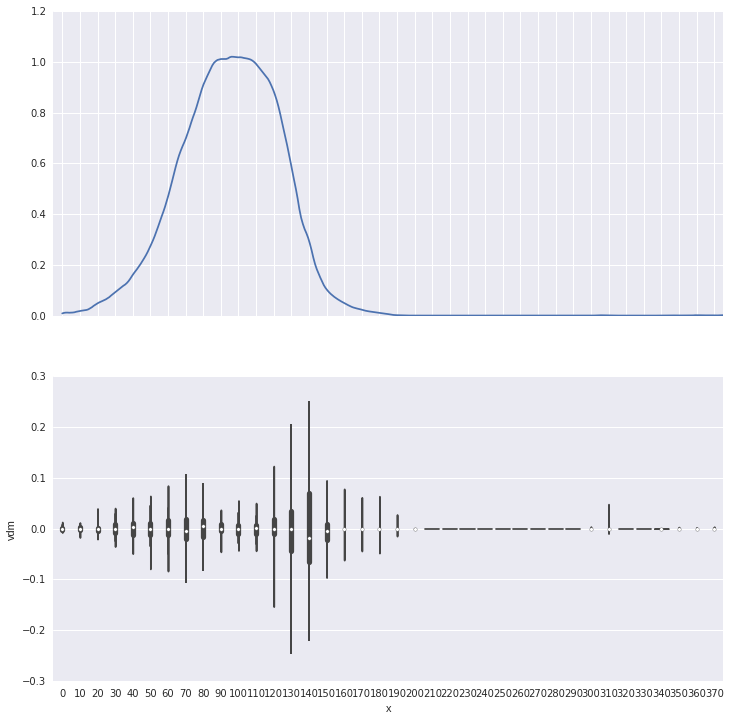

In [444]:
_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 12))

sns.violinplot(
    x='x',
    y='vdm',
    data=

(images_ser
         .reindex(x_idx[::10], level='x')
         .to_frame('v')
         .reset_index()
         .join(structs, on='sid')
         .pipe(lambda df: df.assign(vdm=(
            df.groupby(['normalized','x','wine','c'])
            .v
            .transform(lambda s: s-s.mean()))))
 .query("(normalized==True) and (c=='b')")
), ax=ax2)

(images_ser
 .loc[True]
 .xs('b', level='c')
 .groupby(level='x')
 .mean()
 .pipe(lambda s: ax1.plot(ax2.get_xlim()[1] * s.index / s.index.max(), s.values))
)

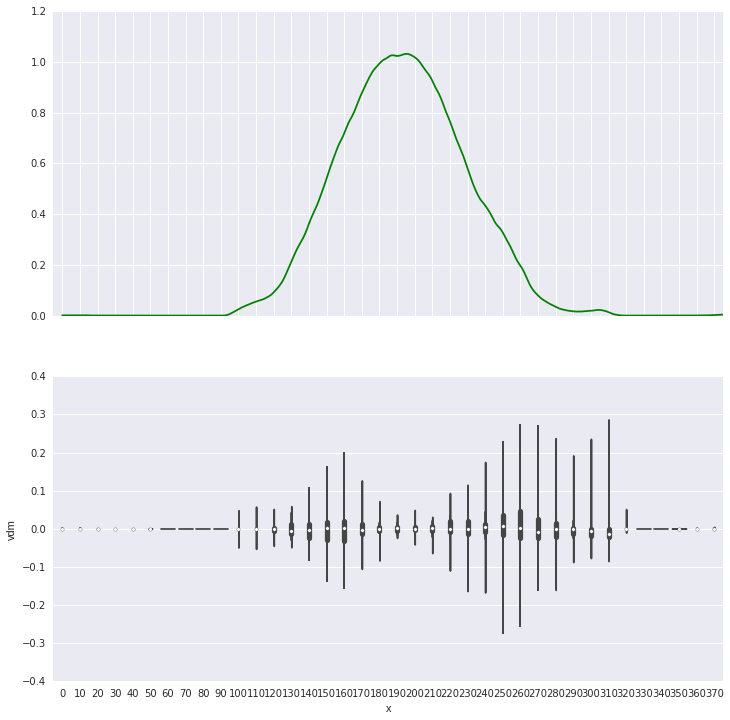

In [447]:
_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 12))

sns.violinplot(
    x='x',
    y='vdm',
    data=

(images_ser
         .reindex(x_idx[::10], level='x')
         .to_frame('v')
         .reset_index()
         .join(structs, on='sid')
         .pipe(lambda df: df.assign(vdm=(
            df.groupby(['normalized','x','wine','c'])
            .v
            .transform(lambda s: s-s.mean()))))
 .query("(normalized==True) and (c=='g')")
), ax=ax2)

(images_ser
 .loc[True]
 .xs('g', level='c')
 .groupby(level='x')
 .mean()
 .pipe(lambda s: ax1.plot(ax2.get_xlim()[1] * s.index / s.index.max(), s.values, color='g'))
)

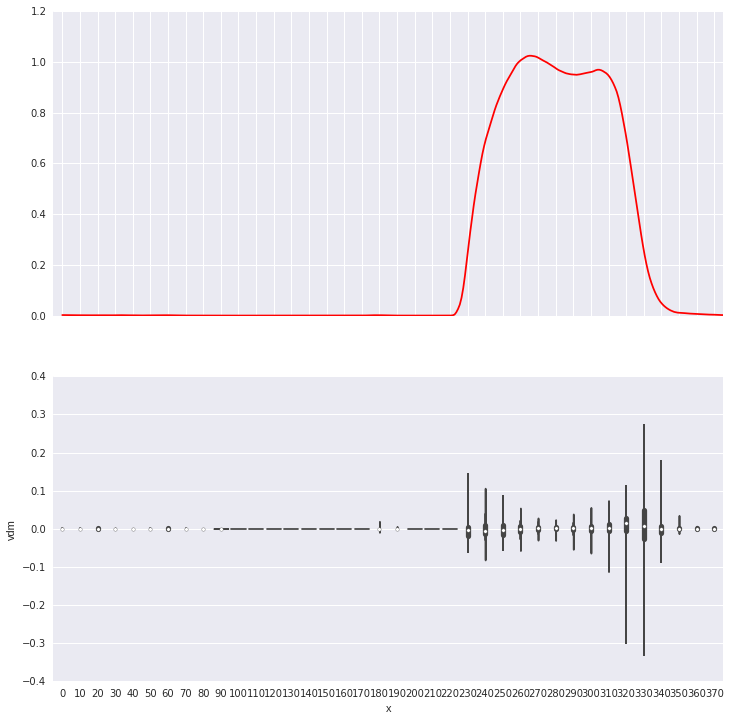

In [448]:
_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 12))

sns.violinplot(
    x='x',
    y='vdm',
    data=

(images_ser
         .reindex(x_idx[::10], level='x')
         .to_frame('v')
         .reset_index()
         .join(structs, on='sid')
         .pipe(lambda df: df.assign(vdm=(
            df.groupby(['normalized','x','wine','c'])
            .v
            .transform(lambda s: s-s.mean()))))
 .query("(normalized==True) and (c=='r')")
), ax=ax2)

(images_ser
 .loc[True]
 .xs('r', level='c')
 .groupby(level='x')
 .mean()
 .pipe(lambda s: ax1.plot(ax2.get_xlim()[1] * s.index / s.index.max(), s.values, color='r'))
)

# Logit model

In [608]:
features = [
    ('b_90'),
    #('b_100'),
    ('b_110'),
    ('g_190'),
    #('g_200'),
    ('g_210'),
    #('r_280'),
    #('r_290'),
    #('r_310'),
]

design_mat = (
 meta_df
 .join(
    (images_ser[True]
     .reset_index()
     .assign(cx=lambda df: df.c+"_"+df.x.astype(str))
     .set_index(['sid','cx'])
     [0]
     .reset_index(level='sid')
     .loc[features]
     .reset_index()
     .pivot(columns='cx', values=0, index='sid')
    ))
)

train = design_mat.sample(int(len(design_mat)*0.8))
test = design_mat.loc[design_mat.index.difference(train.index)]

model = smf.mnlogit(
    formula="wine ~ %s" % "+".join(["standardize(%s)" % f for f in features]),
    data=train,
)
res = model.fit_regularized(alpha=4)
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.14075966799
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                   38
Model:                        MNLogit   Df Residuals:                       33
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 Aug 2016   Pseudo R-squ.:                  0.3875
Time:                        16:25:44   Log-Likelihood:                -32.103
converged:                       True   LL-Null:                       -52.415
                                        LLR p-value:                 1.509e-09
         y=wine[B]       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------

/home/brian/bin/ipython3-env/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:598: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  start_params = np.zeros((self.K * (self.J-1)))
/home/brian/bin/ipython3-env/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1697: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  params = params.reshape(self.K, -1, order='F')
/home/brian/bin/ipython3-env/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1756: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  params = params.reshape(self.K, -1, order='F')
/home/brian/bin/ipython3-env/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in t

In [609]:
cm = sns.light_palette("muted blue", input='xkcd', as_cmap=True)
(
 test[['wine']]
 .join(
    pd.DataFrame(res.predict(test), index=test.index, columns=['A','B','C','D']).add_prefix("prob_")
    .assign(top_prediction=lambda df: df.idxmax(axis=1).str[5:])
 )
 .style
 .background_gradient(subset=['prob_A','prob_B','prob_C','prob_D'], axis=1, cmap=cm)
)

# Day 1 plotting

In [ ]:
def norm_ser(a):
    #return a/np.mean(a)
    return a

c1, c2 = sns.color_palette('Set1', n_colors=2)

_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
for id_, meta in samples.query("not hasfilt").iterrows():
    ax1.plot(
        norm_ser(np.mean(images[id_][:,:,0], axis=0)[200:520]),
        color=c1 if meta['wine' ] == 'A' else c2)
    ax1.set_title("red")

    ax2.plot(
        norm_ser(np.mean(images[id_][:,:,1], axis=0)[200:520]),
        color=c1 if meta['wine' ] == 'A' else c2)
    ax2.set_title("green")

    ax3.plot(
        norm_ser(np.mean(images[id_][:,:,2], axis=0)[200:520]),
        color=c1 if meta['wine' ] == 'A' else c2)
    ax3.set_title("blue")

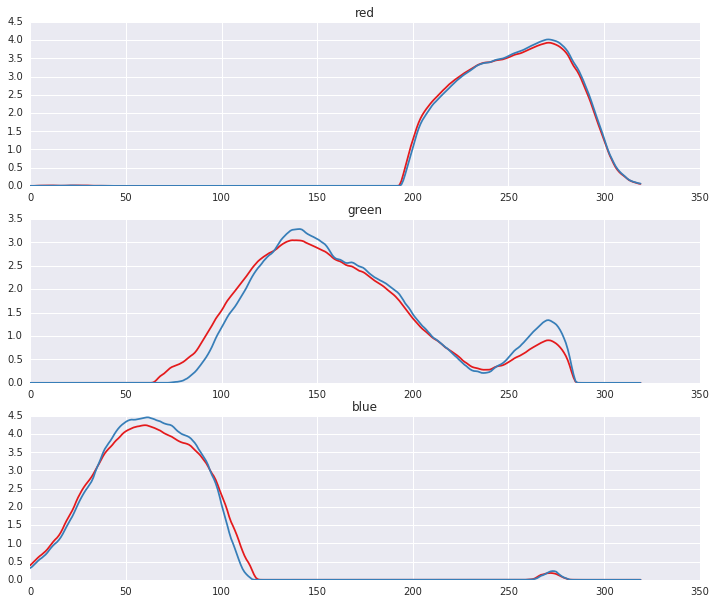

In [80]:
c1, c2 = sns.color_palette('Set1', n_colors=2)

_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
for id_, meta in samples.query("hasfilt").iterrows():
    ax1.plot(
        norm_ser(np.mean(images[id_][:,:,0], axis=0)[200:520]),
        color=c1 if meta['wine' ] == 'Ablue' else c2)
    ax1.set_title("red")

    ax2.plot(
        norm_ser(np.mean(images[id_][:,:,1], axis=0)[200:520]),
        color=c1 if meta['wine' ] == 'Ablue' else c2)
    ax2.set_title("green")

    ax3.plot(
        norm_ser(np.mean(images[id_][:,:,2], axis=0)[200:520]),
        color=c1 if meta['wine' ] == 'Ablue' else c2)
    ax3.set_title("blue")

# model

$$
\begin{array}{rll}
a_i = N(\mu_i,&\sigma_{t}&\\
&+ \sigma_{x}&\\
&+ \sigma_{sample}&\\
&+ \sigma_{pour}&)\\
\end{array}
$$